# Matrix form 

In equations {eq}`global_integral_matrix` and {eq}`global_integral_vector` we still had a global integral and the product of all shape functions $N_i$ with all other shape functions $N_j$. However, we can make use of the fact that every individual shape function (and hence its derivatives) is equal to zero for the largest part of the domain, only different from zero at the set of elements attach to the corresponding node. Moreover, we can always split the integral in a sum of integrals over subdomains. Then, since the pice-wise polynomials are defined on each element $\Omega_k$, it is useful to select these subdomains as the **elements** of the mesh.

## Elemental matrix and vector
 
We can then define the element matrix considering only those shape functions that are active in the element. 

```{figure} ./figures/1_4_4.png
---
height: 200px
name: 1_4_4
---
Linear two-node element
```

Using piece-wise linear shape functions, we have that for a given element $k$, the shape functions associated to nodes $a$ and $b$ are:

$$ N_a(x) = \frac{x_b-x}{x_b-x_a}=\frac{x_b-x}{\Delta x}, \quad N_b(x)=\frac{x-x_a}{x_b-x_a}=\frac{x-x_a}{\Delta x},
$$

where $x_a$ and $x_b$ are the $x$-coordinates of the two nodes of the element. 

This elemental shape function matrix $\mathbf{N}=\left[N_a\ \ N_b\right]$ can be defined as a python function. It can be convenient to work with local coordinates, which can be generalized to the concept of iso-parametric mapping. If you are curious how this is generally done in finite elements, there is additional material on numerical integration and iso-parametric mapping in the [Videos](./videos.md) chapter. Here, we work with local coordinates $x_\text{local} = x-x_a$:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Returns the evaluated N matrix
# - The local coordinate of evaluation "x_local"
# - The element size "dx"
def evaluate_N(x_local, dx):
    return np.array([[1-x_local/dx, x_local/dx]])

We can also define the shape functions derivative, which for piece-wise linear functions is:

$$\frac{\partial N_a}{\partial x}(x)=\frac{-1}{\Delta x},\quad \frac{\partial N_b}{\partial x}(x)=\frac{1}{\Delta x}.
$$

If we introduce the $\mathbf{B}$ matrix (size $1\times 2$) to collect the derivatives of the shape functions in the element, we can write the element matrix as:

$$ \mathbf{K}_e = \int_{x_a}^{x_b} \mathbf{B}^T EA \mathbf{B} \,dx. $$

For the 1D element with linear shape functions, $\mathbf{B}$ is defined as: 

$$\mathbf{B} = \left[\begin{matrix}\frac{-1}{\Delta x} & \frac{1}{\Delta x}\end{matrix}\right]$$

with $\Delta x = x_b-x_a$. Note that for the linear shape functions, $\mathbf{B}$ is constant over the element. In general, that is not always the case.

In [3]:
# Returns the evaluated B vector
# - The local coordinate of evaluation "x_local"
# - The element size "dx"
def evaluate_B(x_local, dx):
    return np.array([[-1/dx, 1/dx]])

Assuming a constant $EA$, evaluating the integrand over the element domain results in:

$$ \mathbf{K}_e = \frac{EA}{\Delta x}\left[\begin{matrix}1 & -1 \\ -1 & 1\end{matrix}\right].$$ (element_matrix)

We can also define a python function to compute the elemental matrix. Here we make use of numerical integration, as introduced in the [numerical methods](../numerical_methods/2-numerical-interp.ipynb) chapter. For this specific case numerical integration is not necessary because we integrate a constant. However, for more complex shape functions, this is the most efficient approach.

In [4]:
# Returning the matrix of a single element
# - The stiffness of the rod "EA"
# - The length of an element "dx"
def get_element_matrix(EA, dx):
    
    # Defining integration locations and weights
    integration_locations = [(dx - dx/(3**0.5))/2, (dx + dx/(3**0.5))/2]
    integration_weights = [dx/2, dx/2]
    n_ip = len(integration_weights)

    # Setting up the local element matrix
    n_node = 2
    K_loc = np.zeros((n_node,n_node))

    # Evaluation of the matrix in a loop over integration points
    for x_ip, w_ip in zip(integration_locations, integration_weights):
        B = evaluate_B(x_ip, dx)
        K_loc += EA*np.dot(np.transpose(B), B)*w_ip

    return K_loc

Similarly, for an element not attached to the boundary nodes, the elemental force vector is

$$ \mathbf{f}_e = \int_{x_a}^{x_b} \mathbf{N}^T q \,dx. $$


In [5]:
# Returning the force vector of a single element (distrubted load only)
# - The magnitude of the distributed load "q"
# - The length of the element "dx"
def get_element_force(q, dx):
    # Creating a matrix with the required size
    n_node = 2
    N = np.zeros((1,n_node))    # Defining in 2 dimensions is nessecary for transpose
    
    # Defining integration locations and weights
    integration_locations = [(dx - dx/(3**0.5))/2, (dx + dx/(3**0.5))/2]
    integration_weights = [dx/2, dx/2]
    
    # Setting up the local element force vector
    f_loc = np.zeros((n_node,1))
    
    for x_ip, w_ip in zip(integration_locations, integration_weights):
        N = evaluate_N(x_ip,dx)
        f_loc += np.transpose(N)*q*w_ip

    return f_loc

## Global matrix and vector

Once each elemental matrix is defined, we need to assemble the elemental contributions to the corresponding entries of the global matrix. 

To showcase this step we discretize the rod with three elements of equal length. We give each element and node a number, there are 4 nodes, numbered $n_1$ to $n_4$ and 3 elements numbered $e_1$ to $e_3$, see {numref}`rodDiscretized`.

```{figure} ./figures/barDefinition-3.png
---
height: 150px
name: rodDiscretized
---
One dimensional rod discretized into 3 elements
```

By a simple addition of the influences of each element we can find the total $\mathbf{K}$ matrix:

$$
\mathbf{K} = \frac{EA}{\Delta x} \left(\left[\begin{matrix}1 & -1 & 0 & 0 \\ -1 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{matrix}\right] + \left[\begin{matrix}0 & 0 & 0 & 0 \\ 0 & 1 & -1 & 0 \\ 0 & -1 & 1 & 0 \\ 0 & 0 & 0 & 0 \end{matrix}\right] + \left[\begin{matrix}0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & -1 \\ 0 & 0 & -1 & 1 \end{matrix}\right] \right) $$ (assembly)

After assembly of all the local matrices, we have the global $\mathbf{K}$ matrix:

$$
\mathbf{K} = \frac{EA}{\Delta x}\left[\begin{matrix}1 & -1 & 0 & 0 \\ -1 & 2 & -1 & 0 \\ 0 & -1 & 2 & -1 \\ 0 & 0 & -1 & 1 \end{matrix}\right] 
$$ (sumofmatrixes)


In practice it is very inefficient to compute the element matrices at the same size as the global matrices. You can see in the operation above quite some zeros are added every time an element matrix is added. It is better to evaluate smaller element matrices (as in equation {eq}`element_matrix`) that only contain the nonzero values and then put in the right position in an assembly operation. Some bookkeeping is needed to know which nodes (or degrees of freedom) belong to which elements. For our 1D mesh, this is very simple, as reflected by the function below.

In [6]:
def get_nodes_for_element(ie):
    return np.array([ie,ie+1])

For putting the element matrix in the right position, we make use of the `numpy.ix_` function. A naive implementation of the assembly operation would be to do:

```Python
    elnodes = get_nodes_for_element(i)
    K_local = get_element_matrix(EA, dx)
    for k in range(2):
        for l in range(2):
            K_global[elnodes[k], elnodes[l]] += K_local[k, l]
```
However, this double loop can be vectorized with the `numpy` function `ix_`, where the function `ix_` is used to access the relevant submatrix from the global matrix:
```Python
    elnodes = get_nodes_for_element(i)
    K_global[np.ix_(elnodes, elnodes)] += get_element_matrix(EA, dx)
```

In [7]:
# - The length of the rod "rod_length"
# - The number of elements "n_el"
# - The stiffness of the rod "EA"
def assemble_global_K(rod_length, n_el, EA):
    n_DOF = n_el+1
    dx = rod_length/n_el
    K_global = np.zeros((n_DOF, n_DOF))
    
    for i in range(n_el):
        elnodes = get_nodes_for_element(i)
        K_global[np.ix_(elnodes,elnodes)] += get_element_matrix(EA, dx)
    
    return K_global

To solve for global equilibrium, we need to equate the product $\mathbf{Ku}$ to a vector with external forces. Point loads on a node can directly be inserted on the right hand side vector of the equation $\mathbf{Ku}=\mathbf{f}$, while a distributed load $f$ is translated to a load vector with the expression from the derivation:

$$
\mathbf{f}=\int_0^L\mathbf{N}^Tf\,dx
$$ (distributedload)

For this example we define a constant distributed load $f(x)=q$, which leads to an elemental vector of $\mathbf{f}^e=[\frac{q\Delta x}{2}\ \ \frac{q\Delta x}{2}]^T$. With this elemental force, we can again assemble to a global vector as done in the following function.

In [8]:
# Returns the global f vector with continuous forces on a rod
# - The length of the rod "rod_length"
# - The number of elements "n_el"
# - The force on the rod "EA"
def assemble_global_f(rod_length, n_el, q):
    n_DOF = n_el+1
    dx = rod_length/n_el
    f_global = np.zeros((n_DOF,1))
    
    for i in range(n_el):
        elnodes = get_nodes_for_element(i) 
        f_global[elnodes] += get_element_force(q, dx)
        
    return np.squeeze(f_global)


## Boundary conditions

We have now derived the relation between $\mathbf{u}$ and $\mathbf{f}$ through a matrix $\mathbf{K}$. However, when we try to solve the equation $\mathbf{K u} = \mathbf{f}$, we will run into a problem. On the left hand side one of the values for $u$ is already known, the displacement of the left node ($n_0$) will be zero. The corresponding force $f_1$ is as of yet unknown. Since there is unknowns on either side of the equation we cannot solve it by inverting $\mathbf{K}$ and bringing it to the other side.

$$
\frac{EA}{\Delta x}\left[\begin{matrix}1 & -1 & 0 & 0 \\ -1 & 2 & -1 & 0 \\ 0 & -1 & 2 & -1 \\ 0 & 0 & -1 & 1 \end{matrix}\right] \left[\begin{matrix}0 \\ u_2? \\ u_3? \\ u_4?\end{matrix}\right] = \left[\begin{matrix}f_1? \\ \frac{q}{\Delta x} \\ \frac{q}{\Delta x} \\ \frac{q}{2\Delta x}+F\end{matrix}\right]
$$ (totalmatrix)

A way to overcome this problem is to leave out equations belonging to nodes for which the solution is known. As long as the fixed degrees of freedom are prescribed at a value of 0 (i.e. homogeneous Dirichlet conditions), we can do this by simply removing the corresponding columns and rows out of our system. Doing that for node 0 in our example, we get:

$$
\frac{EA}{\Delta x}\left[\begin{matrix} 2 & -1 & 0 \\ -1 & 2 & -1 \\ 0 & -1 & 1 \end{matrix}\right] \left[\begin{matrix}u_2? \\ u_3? \\ u_4?\end{matrix}\right] = \left[\begin{matrix} \frac{q}{\Delta x} \\ \frac{q}{\Delta x} \\ \frac{q}{2\Delta x}+F\end{matrix}\right]
$$ (totalmatrix_afterbcs)

This system can solved by inverting $\mathbf{K}$ or, more efficiently, by using an appropriate linear solver. It is important to note that for nonzero Dirichlet conditions, additional steps need to be taken.

Solving the system of equations above will finally result in a vector with values for the nodal displacements $\mathbf{u}$. Note that with the shape functions, we also have an interpolation between the nodes, so a continuous approximate solution $u^h(x)$ can be obtained with:

$$
u^h(x) = \mathbf{N}\mathbf{u}
$$ (continuoussolution)

Moreover, the reaction force $f_1$ can be computed by multiplying first row from the complete $4\times4$-matrix with the nodal displacement vector.

The function `simulate` returns the solution of the problem given the number of discrete elements. At this point we also need to give numbers to the parameters of the problem. We will use $L=3$ m, $EA=10^3$ N, $F=10$ N and $q=-10$ N/m.

In [9]:
def simulate(n_element):
    length = 3              # Length
    EA = 1e3                # Stiffness EA
    n_node = n_element + 1  # Number of nodes
    F_right = 10            # Load applied at the right boundary
    u_left = 0              # Displacement at the left boundary
    q_load = -10            # Distibuted load

    dx = length/n_element
    x = np.linspace(0,length,n_node)

    # Assmemble K for the rod problem
    K = assemble_global_K(length, n_element, EA)

    # Assemble f first with distributed load only
    f = assemble_global_f(length, n_element, q_load)

    # Add boundary conditions to f
    f[n_node-1] += F_right

    # Initialize vector u with displacements
    u = np.zeros(n_node)

    # Solve the system for unknown displacements
    K_inv = np.linalg.inv(K[1:n_node, 1:n_node])
    u[1:n_node] = np.dot(K_inv, f[1:n_node])

    return x, u

Finally, we can run the simulation and inspect the results:

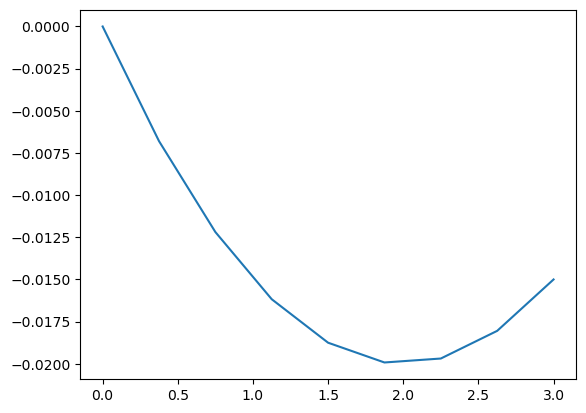

In [11]:
x, u = simulate(8)
plt.figure()
plt.plot(x,u);

In the following widget you can see how the solution converges to the analytical solution when we increase the number of elements.

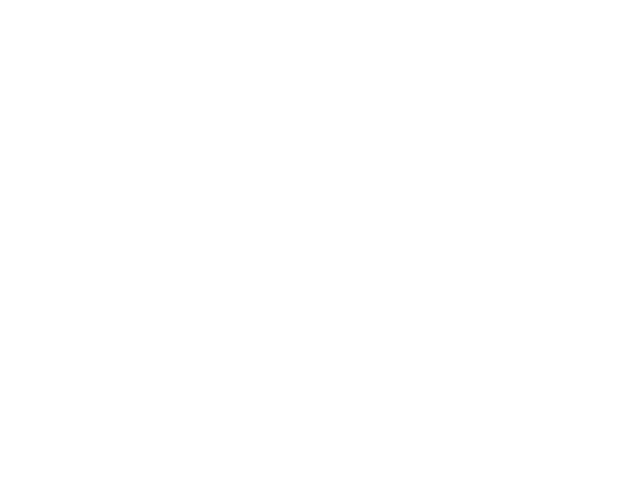

In [12]:
%matplotlib widget

import matplotlib.pyplot as plt
import plotly.subplots as sp
import plotly.graph_objects as go

plt.figure()
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 2})

In [13]:
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

# Colors
grey = '#eeeeee' # light grey fill

## Prepare all the graphs that are to be plotted
# Define the range of densities to plot
range_elements = np.arange(1, 9, 1)

## Create plot
fig = go.Figure()

base_traces = 0 # Number of traces that are always visible

length = 3              # Length
EA = 1e3                # Stiffness EA
F_right = 10            # Load applied at the right boundary
u_left = 0              # Displacement at the left boundary
q_load = -10            # Distibuted load

x_analytical = np.linspace(0, length, 1000)
u_analytical = -(q_load * ((x_analytical - length)**2 - length**2)) / (2 * EA) + (F_right / EA) * x_analytical

# Add traces, one for each slider step
for a in range_elements: 
    x, u  = simulate(a)
    fig.add_trace(  
        go.Scatter(
            visible=False,
            x=x_analytical,
            y=u_analytical,
            line=dict(color='#FFA500'),
            mode='lines',
            name='Exact solution'))
    fig.add_trace(        
        go.Scatter(
            visible=False,
            x=x,
            y=u,
            line=dict(color='#6a8ba4'),
            mode='lines',
            name='FE solution'))

traces_per_step = 2 # Number of traces per value of a

# Show the traces for one value of a when loading the plot (initial setup)
active_a_index = 1
for i in range(traces_per_step):
    curr_idx = int(base_traces + active_a_index*traces_per_step + i)
    fig.data[curr_idx].visible = True

# Create and add slider
steps = []
for i in range(0, range_elements.shape[0]):
    visarray = [False] * len(fig.data)
    visarray[0:base_traces] = [True] * base_traces
    curr_idx = int(base_traces + i * traces_per_step)
    next_idx = int(base_traces + (i+1) * traces_per_step)
    visarray[curr_idx:next_idx] = [True] * traces_per_step
    step = dict(
        method="update",
        args=[{"visible": visarray}],
        label=str(round(range_elements[i], 1))
    )
    steps.append(step)

sliders = [dict(
    active=active_a_index,
    currentvalue={"prefix": r"Number of elements: "},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    legend_title="Legend",
)

fig.update_xaxes(title_text='x (m)', range=[-0.1, 3.1])

# Update yaxis properties
fig.update_yaxes(title_text='u (m)', range=[-0.025, 0.005])

fig.update_layout(
    title="Displacement of axially loaded rod",
    sliders=sliders,
    legend_title="Legend"
)

fig

:::{card} Quiz question
<iframe src="https://tudelft.h5p.com/content/1292102826908930637/embed" aria-label="Changing the mesh" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>
:::

:::{card} Exercise

In which functions is the numerical integration procedure implemented? (Hint: there are two)

```{admonition} Solution
:class: tip, dropdown
In the functions `get_element_force` and `get_element_matrix`
```

In these functions, which variables contain information on the integration scheme?

```{admonition} Solution
:class: tip, dropdown
The variables `integration_locations` and `integration_weights`
```

How many integration points are employed in these functions?

```{admonition} Solution
:class: tip, dropdown
Two integration points (per element)
```


For going to an integration scheme with a single integration point per element, how would you define these two variables?

```{admonition} Solution
:class: tip, dropdown
For 1 point Gauss integration, the integration point needs to be at the center of the element and the integration weight needs to equate the length of the element:

`integration_locations = [ dx/2 ]`
 
`integration_weights = [ dx ]`
```

:::

## Additional case with non-uniform stiffness

The problem above has one peculiar feature, which is that the nodal values always coincide with the exact solution. This is not a property of the finite element method. For completeness, we show the convergence behavior for a slightly more complicated problem, namely one where $EA$ is a linear function of $x$:

$$
EA = 1\cdot10^3(1+\alpha x)
$$

with $\alpha=0.5$ m$^{-1}$.
With the same boundary conditions, we get a convergence behavior is more typical for what one can expect from finite element solutions. The FE model still converges to the exact result, but the approximate nature of the solution is now not only visible for the field inside the elements but also for the nodal values themselves. 


In [14]:
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

# Redefine matrix assembly to pass on coordinates

def get_element_matrix(EA0, elcoords):
    
    alpha = 0.5
    dx = elcoords[1] - elcoords[0]
    
    # Defining integration locations and weights
    integration_locations = [(dx - dx/(3**0.5))/2, (dx + dx/(3**0.5))/2]
    integration_weights = [dx/2, dx/2]
    n_ip = len(integration_weights)
    
    # Setting up the local element stiffness matrix
    n_node = 2
    K_loc = np.zeros((n_node,n_node))

    # Evaluation of the stiffness matrix in a loop over integration points
    for x_ip, w_ip in zip(integration_locations, integration_weights):
        B = evaluate_B(x_ip, dx)
        EA_loc = EA0*(1 + alpha * (x_ip + elcoords[0]))
        K_loc += EA_loc*np.dot(np.transpose(B), B)*w_ip

    return K_loc


def assemble_global_K(rod_length, n_el, EA):
    n_DOF = n_el+1
    dx = rod_length/n_el
    K_global = np.zeros((n_DOF, n_DOF))
    
    for i in range(n_el):
        elnodes = get_nodes_for_element(i)
        elcoords = elnodes * dx
        K_global[np.ix_(elnodes,elnodes)] += get_element_matrix(EA, elcoords)
    
    return K_global

# Colors
grey = '#eeeeee' # light grey fill

## Prepare all the graphs that are to be plotted
# Define the range of densities to plot
range_elements = np.arange(1, 9, 1)

## Create plot
fig = go.Figure()

base_traces = 0 # Number of traces that are always visible

length = 3              # Length
EA = 1e3                # Stiffness EA
F_right = 10            # Load applied at the right boundary
u_left = 0              # Displacement at the left boundary
q_load = -10            # Distibuted load
a = 0.5

x_analytical = np.linspace(0, length, 1000)
u_analytical = -q_load/EA*x_analytical/a + (F_right+q_load*(length+1/a))/EA/a*np.log(a*x_analytical+1)

# Add traces, one for each slider step
for a in range_elements: 
    x, u  = simulate(a)
    fig.add_trace(  
        go.Scatter(
            visible=False,
            x=x_analytical,
            y=u_analytical,
            line=dict(color='#FFA500'),
            mode='lines',
            name='Exact solution'))
    fig.add_trace(        
        go.Scatter(
            visible=False,
            x=x,
            y=u,
            line=dict(color='#6a8ba4'),
            mode='lines',
            name='FE solution'))

traces_per_step = 2 # Number of traces per value of a

# Show the traces for one value of a when loading the plot (initial setup)
active_a_index = 1
for i in range(traces_per_step):
    curr_idx = int(base_traces + active_a_index*traces_per_step + i)
    fig.data[curr_idx].visible = True

# Create and add slider
steps = []
for i in range(0, range_elements.shape[0]):
    visarray = [False] * len(fig.data)
    visarray[0:base_traces] = [True] * base_traces
    curr_idx = int(base_traces + i * traces_per_step)
    next_idx = int(base_traces + (i+1) * traces_per_step)
    visarray[curr_idx:next_idx] = [True] * traces_per_step
    step = dict(
        method="update",
        args=[{"visible": visarray}],
        label=str(round(range_elements[i], 1))
    )
    steps.append(step)

sliders = [dict(
    active=active_a_index,
    currentvalue={"prefix": r"Number of elements: "},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    legend_title="Legend",
)

fig.update_xaxes(title_text='x (m)', range=[-0.1, 3.1])

# Update yaxis properties
fig.update_yaxes(title_text='u (m)', range=[-0.018, 0.005])

fig.update_layout(
    title="Displacement of axially loaded rod with non-uniform EA",
    sliders=sliders,
    legend_title="Legend"
)

fig